In [20]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score, GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  r2_score
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [21]:
mat.rcParams.update({'figure.figsize':(20,15),'font.size':14})

In [22]:
covid19_train = pd.read_csv('data week 2/train.csv')
covid19_test = pd.read_csv('data week 2/test.csv')

In [23]:
covid19_train.rename(columns={'Id':'ForecastId'},inplace=True)

In [24]:
covid19_train['Date-All'] = covid19_train['Date'].str.replace('-','').astype(int)
covid19_test['Date-All'] = covid19_test['Date'].str.replace('-','').astype(int)

In [25]:
covid19_train['Date'] = pd.to_datetime(covid19_train['Date'])
covid19_test['Date'] = pd.to_datetime(covid19_test['Date'])

In [26]:
covid19_gdf = covid19_train.groupby(['Date','Country_Region'])['ConfirmedCases'].sum().reset_index()
covid19_gdf['date'] = pd.to_datetime(covid19_gdf['Date'])
covid19_gdf['date'] = covid19_gdf['date'].dt.strftime('%m/%d/%Y')

In [27]:
fig = px.scatter_geo(covid19_gdf.fillna(0), locations="Country_Region", locationmode='country names', 
                     color="ConfirmedCases", size="ConfirmedCases", hover_name="Country_Region", 
                     projection="natural earth", animation_frame="date", 
                     title='Coronavirus Spread', color_continuous_scale="OrRd")
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [28]:
totalCountryCases = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)

totalCountryCases.head(20).plot(kind='bar',color='r')
plt.grid()
plt.show()

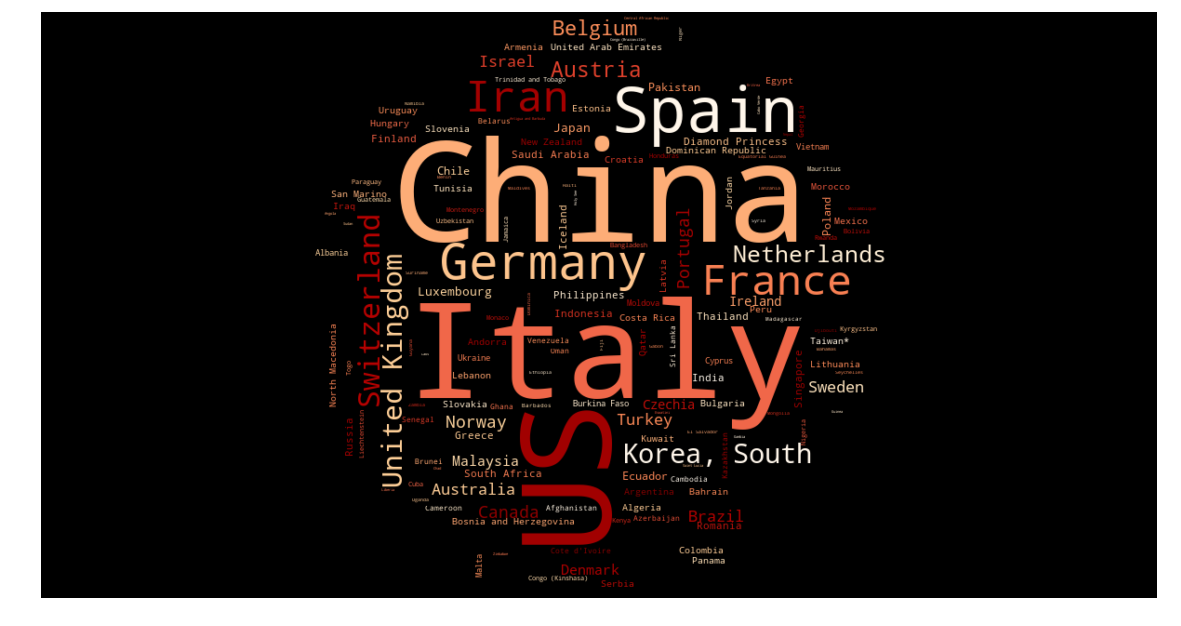

In [30]:
mask=np.array(Image.open("coronavirus.png"))
wc = WordCloud(background_color="black",colormap=plt.cm.OrRd,collocations = False,mask=mask).generate_from_frequencies(totalCountryCases.to_dict()['ConfirmedCases'])
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
wc.to_file('Coronavirus-spread.png')
plt.show()


In [31]:

totalCountryFatalities = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['Fatalities']].sum().sort_values('Fatalities',ascending=False)

totalCountryFatalities.head(20).plot(kind='bar',color='r')
plt.grid()
plt.show()

In [50]:
(totalCountryFatalities['Fatalities'].sum()/totalCountryCases['ConfirmedCases'].sum())*100

4.530228618364763

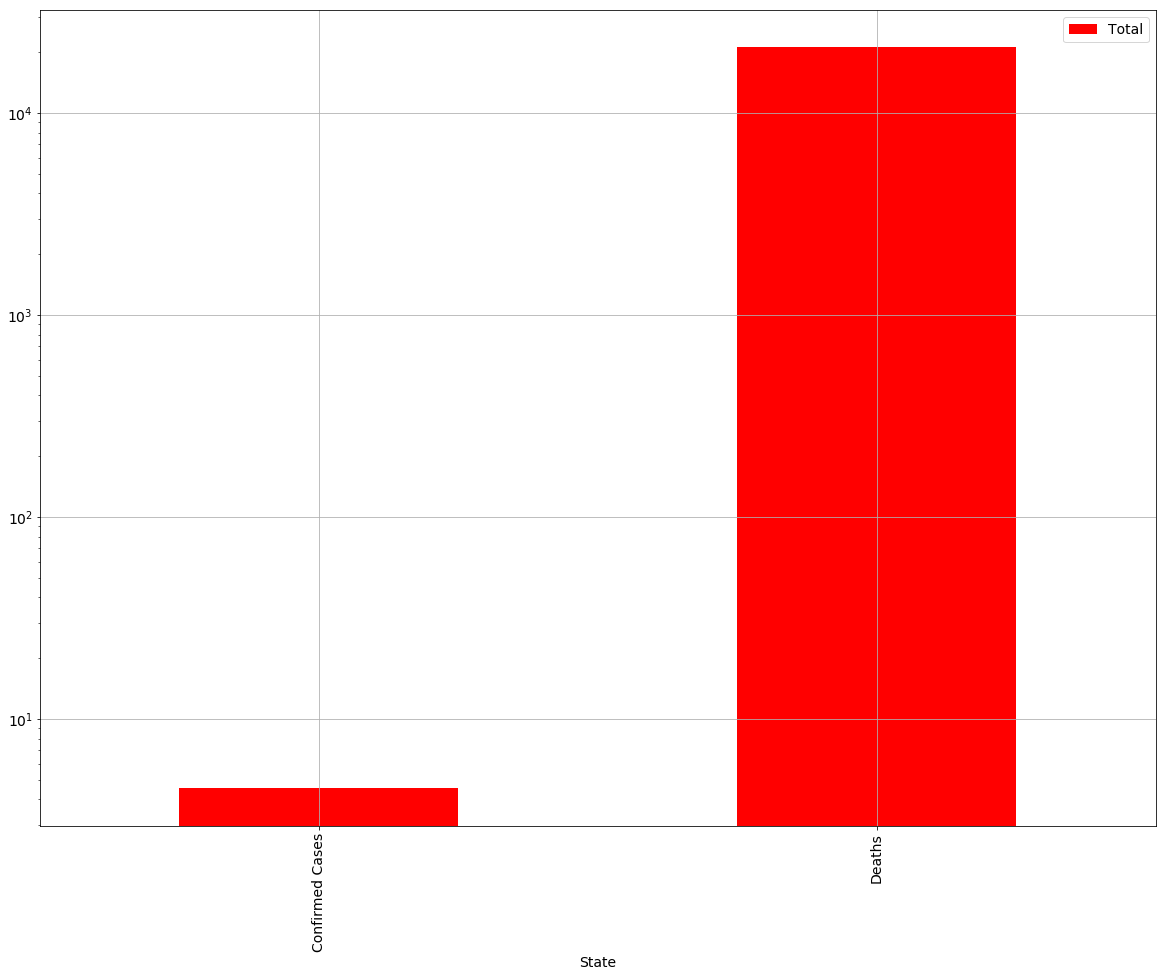

In [49]:
pd.DataFrame({'Total':[(totalCountryFatalities['Fatalities'].sum()/totalCountryCases['ConfirmedCases'].sum())*100, totalCountryFatalities['Fatalities'].sum()],
             'State': ['Confirmed Cases', 'Deaths']}).set_index('State').plot(kind='bar',color='r')
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
totalCountryFatalities = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['Fatalities']].sum().sort_values('Fatalities',ascending=False)

totalCountryFatalities.head(20).plot(kind='bar',color='r')
plt.grid()
plt.show()

In [14]:
totalDailyCases = covid19_train.groupby(['Date'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)

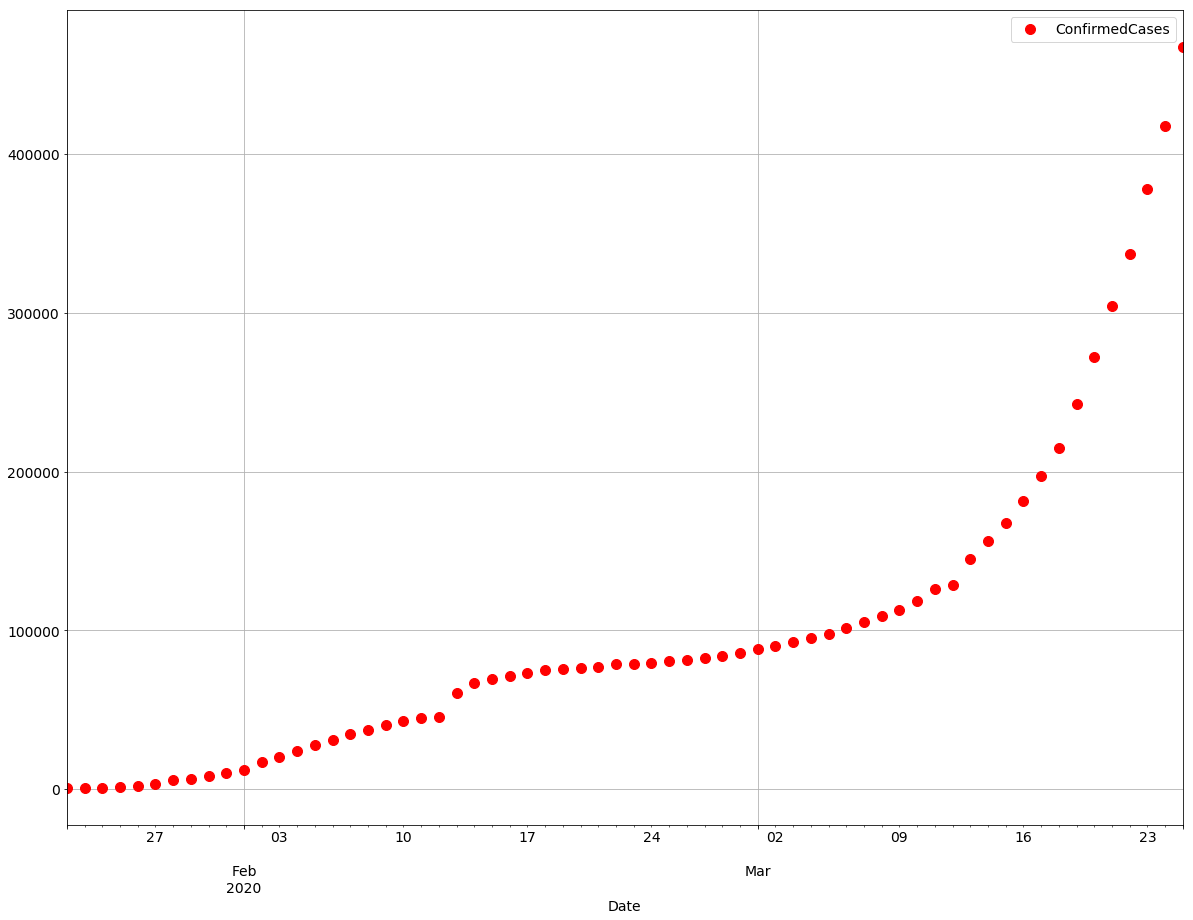

In [33]:
totalDailyCases.plot(grid=True,linestyle='', marker='.',color='r',markersize=20)
plt.show()

# 80% of the infections were in last 30 Days

In [34]:
totalDailyCases['prop'] = round((totalDailyCases['ConfirmedCases'].cumsum()/totalDailyCases['ConfirmedCases'].sum())*100,2)

In [35]:
len(totalDailyCases.loc[totalDailyCases['prop'] <= 80])

30

# First Case Daignosed in November 17

A proportion of 23% from last days had the highest spread

In [36]:
len(totalDailyCases.loc[totalDailyCases['prop'] <= 80])/(len(totalDailyCases)+len(pd.date_range('17-11-2019','21-01-2020')))

0.23076923076923078

# Forecasting

In [17]:
dependant_vars = ['ConfirmedCases', 'Fatalities']
y_train_CC = covid19_train.loc[:,[dependant_vars[0]]].values
y_train_fa = covid19_train.loc[:,[dependant_vars[1]]].values

In [18]:
X = pd.concat([covid19_train.drop(dependant_vars,1), covid19_test],sort=False).set_index('ForecastId')

In [19]:
X = pd.get_dummies(X,drop_first=True)

In [20]:
X_train = X.iloc[:len(covid19_train),:].drop('Date',1).copy()
X_test = X.iloc[len(covid19_train):,:].drop('Date',1).copy()

In [21]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, 
    scoring='neg_mean_squared_error', verbose=0, n_jobs=3)
    
grid_result = gsc.fit(X_train, y_train_CC.reshape(-1))
best_params = grid_result.best_params_

In [22]:
best_params

{'max_depth': 3, 'n_estimators': 1000}

In [23]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               
                            random_state=False, verbose=False)

In [24]:
scores = cross_val_score(rfr, X_train, y_train_CC.reshape(-1), cv=10, scoring='neg_mean_squared_error')

In [25]:
np.sqrt(abs(np.mean(scores)))

3605.1354794410404

In [26]:
predictions = cross_val_predict(rfr, X_train, y_train_CC.reshape(-1), cv=10)

In [27]:
kf = KFold(n_splits = 10, shuffle=True)

In [28]:
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               
                            random_state=False, verbose=False)

In [29]:
rmse = []

In [30]:
for i in range(10):
    offset = next(kf.split(X_train),None)
    x_train = X_train.iloc[offset[0]]
    x_test = X_train.iloc[offset[1]]
    Y_train = y_train_CC[offset[0]]
    Y_test = y_train_CC[offset[1]]

    reg.fit(x_train, Y_train.reshape(-1))
    ypred = reg.predict(x_test)
    rmse.append(np.sqrt(mean_squared_error(Y_test, ypred)))

In [31]:
rmse

[1321.3034268227175,
 652.9178055522094,
 1293.4371864575187,
 1214.4061643584191,
 1111.101419444291,
 1308.9561948569603,
 1035.7829143791694,
 1055.992990543759,
 1481.6183718520529,
 790.881448445681]

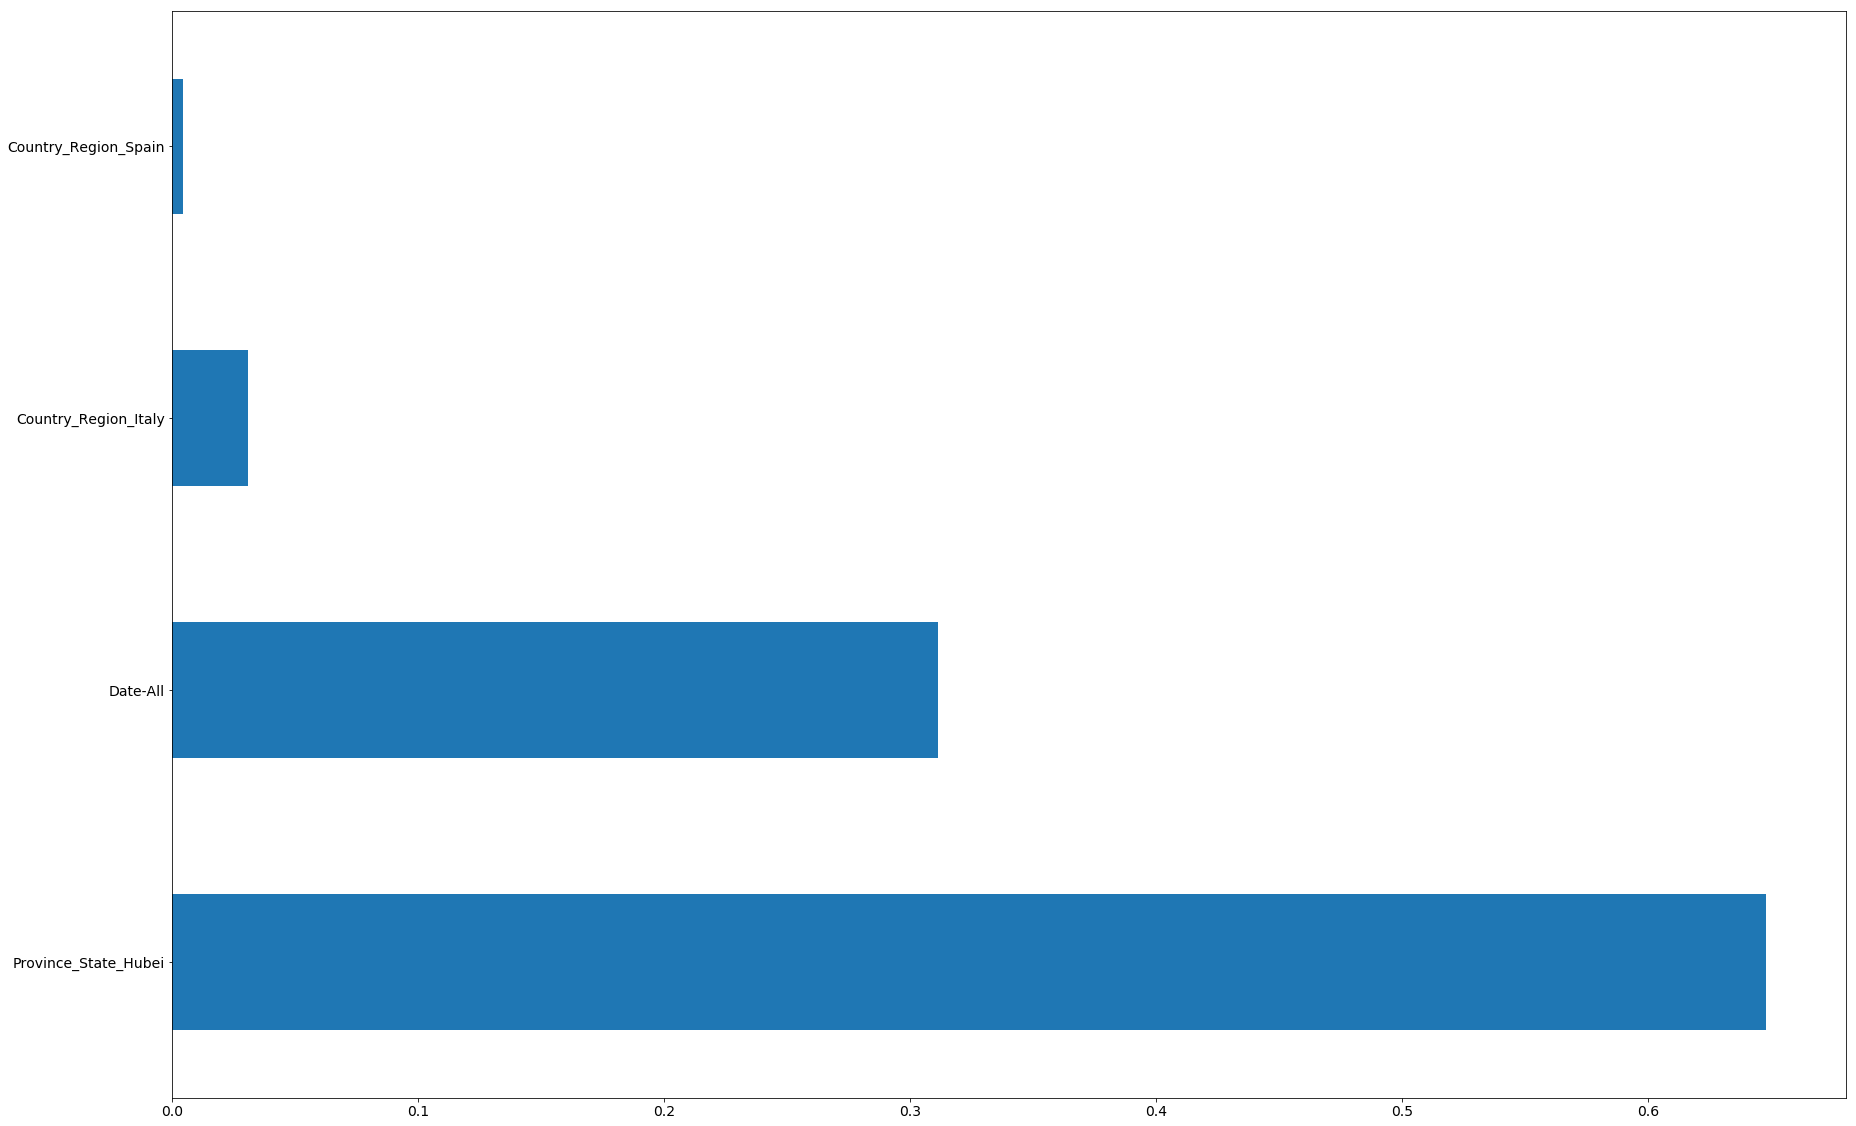

In [32]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

In [33]:
X['yPred'] = reg.predict(X.drop(['Date'],1))

In [34]:
X['yPred'] = X['yPred'].apply(round)
X.loc[X['yPred'] < 0, 'yPred'] = 0

In [35]:
X.loc[:covid19_train.ForecastId.max(),'ConfirmedCases'] = y_train_CC

In [36]:
np.sqrt(mean_squared_error(y_true=X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                   y_pred=X.loc[~X['ConfirmedCases'].isna()]['yPred']))

1208.0056702481224

In [37]:
r2_score(X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                               X.loc[~X['ConfirmedCases'].isna()]['yPred'])

0.8861414558132036

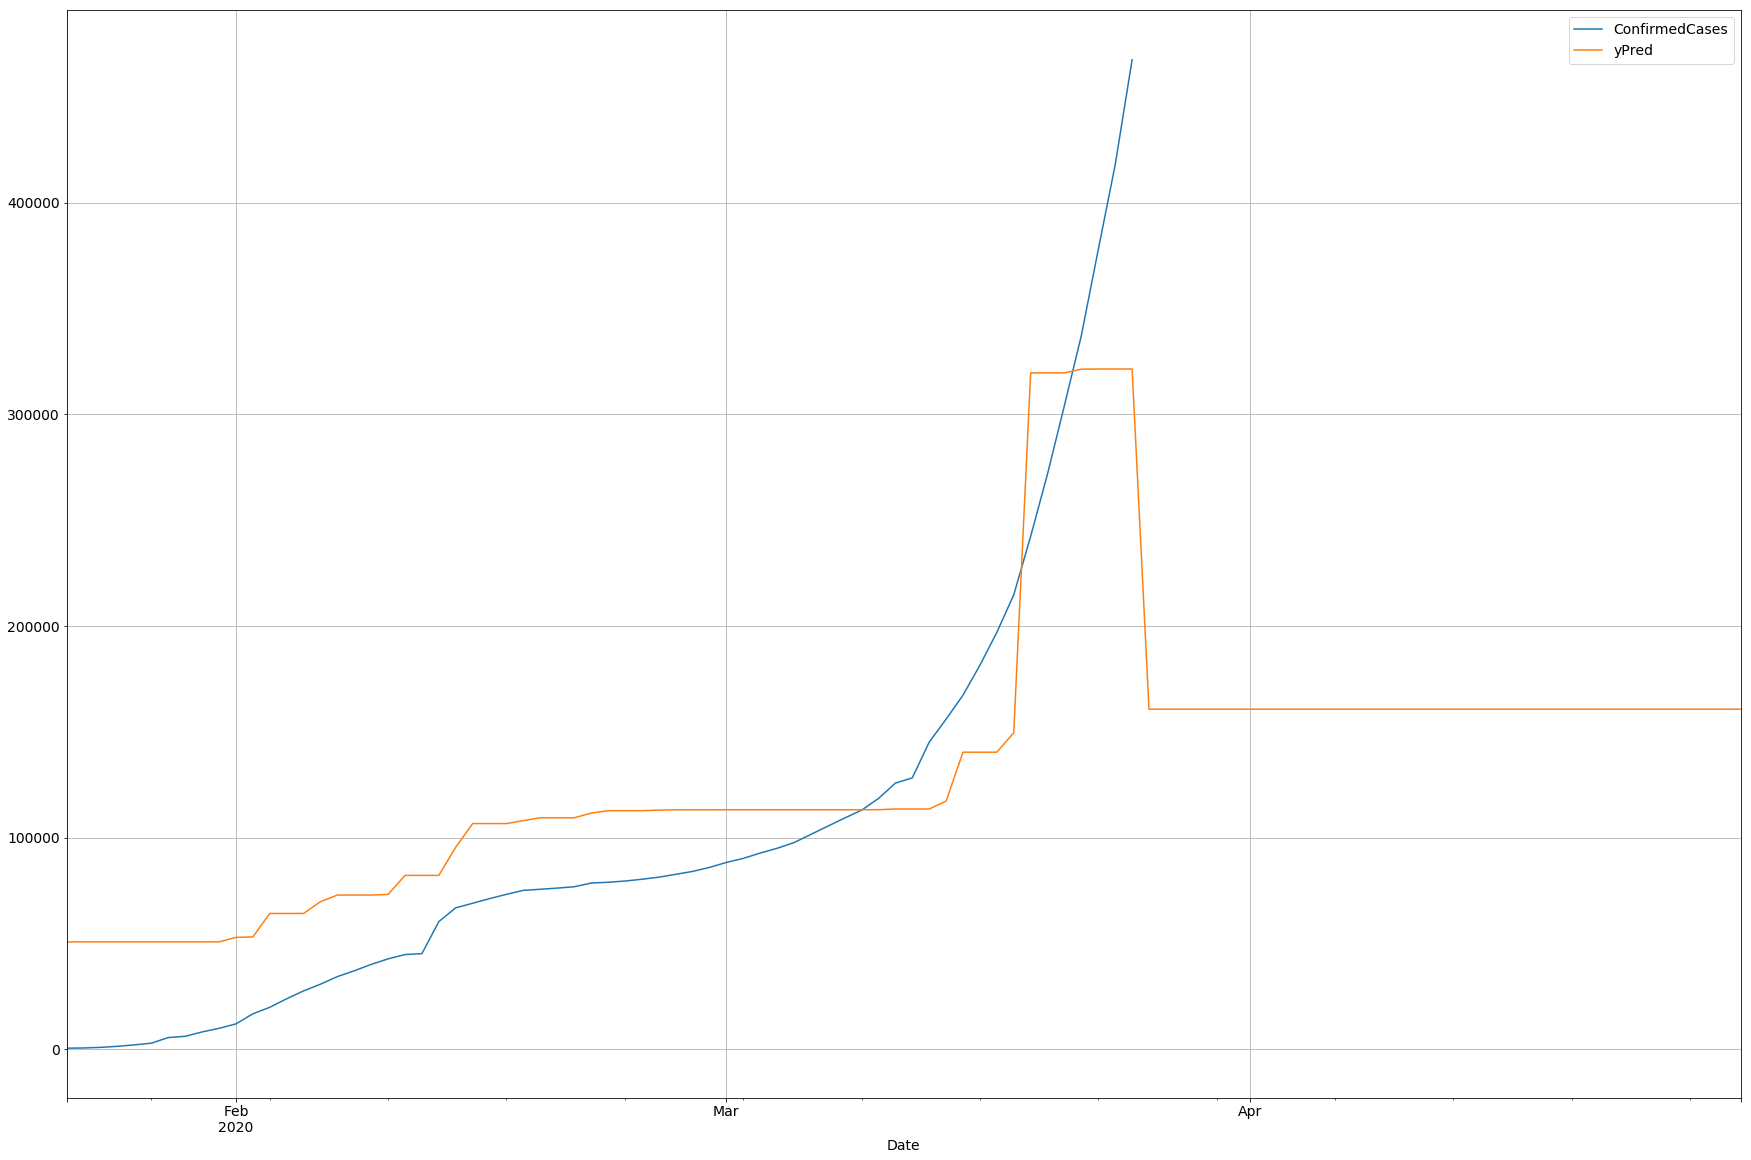

In [38]:
X.set_index('Date').resample('D')[['ConfirmedCases']].sum().replace(0,np.nan).join(X.set_index('Date').resample('D')[['yPred']].sum()).plot(grid=True)

In [39]:
X.drop(['yPred','ConfirmedCases'],1,inplace=True)

In [43]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7, 0.85],
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Instantiate the regressor: gbm
gbm =  xgb.XGBRegressor(objective = "reg:squarederror",tree_method='gpu_hist', gpu_id=0,nthread=4, seed=42)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(n_jobs=5,param_grid=gbm_param_grid, estimator=gbm, scoring= 'neg_mean_squared_error', cv = 4, verbose=0)


# Fit grid_mse to the data
grid_mse.fit(X_train, y_train_CC)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Lowest RMSE found:  3578.3282484333913


In [44]:
kf = KFold(n_splits = 10, shuffle=True)

In [45]:
reg = xgb.XGBRegressor(objective = "reg:squarederror",colsample_bytree=0.3, max_depth=5, n_estimators = 500, learning_rate = 0.01, gamma = 4,
                       tree_method='gpu_hist', gpu_id=0,seed=42)

In [46]:
rmse = []

In [47]:
for i in range(10):
    offset = next(kf.split(X_train),None)
    x_train = X_train.iloc[offset[0]]
    x_test = X_train.iloc[offset[1]]
    Y_train = y_train_CC[offset[0]]
    Y_test = y_train_CC[offset[1]]

    reg.fit(x_train, Y_train,eval_set=[(x_train, Y_train), 
                  (x_test, Y_test)],
        eval_metric="rmse",verbose=False)
    eval_results = reg.evals_result()
    rmse.append(np.mean(eval_results['validation_0']['rmse']))
    

In [48]:
rmse

[2454.9590944539996,
 2422.072729982,
 2351.1647678380004,
 2406.536860612,
 2435.426798358,
 2449.716929922,
 2429.624580074,
 2311.539840082,
 2442.8571687139997,
 2372.3488916120004]

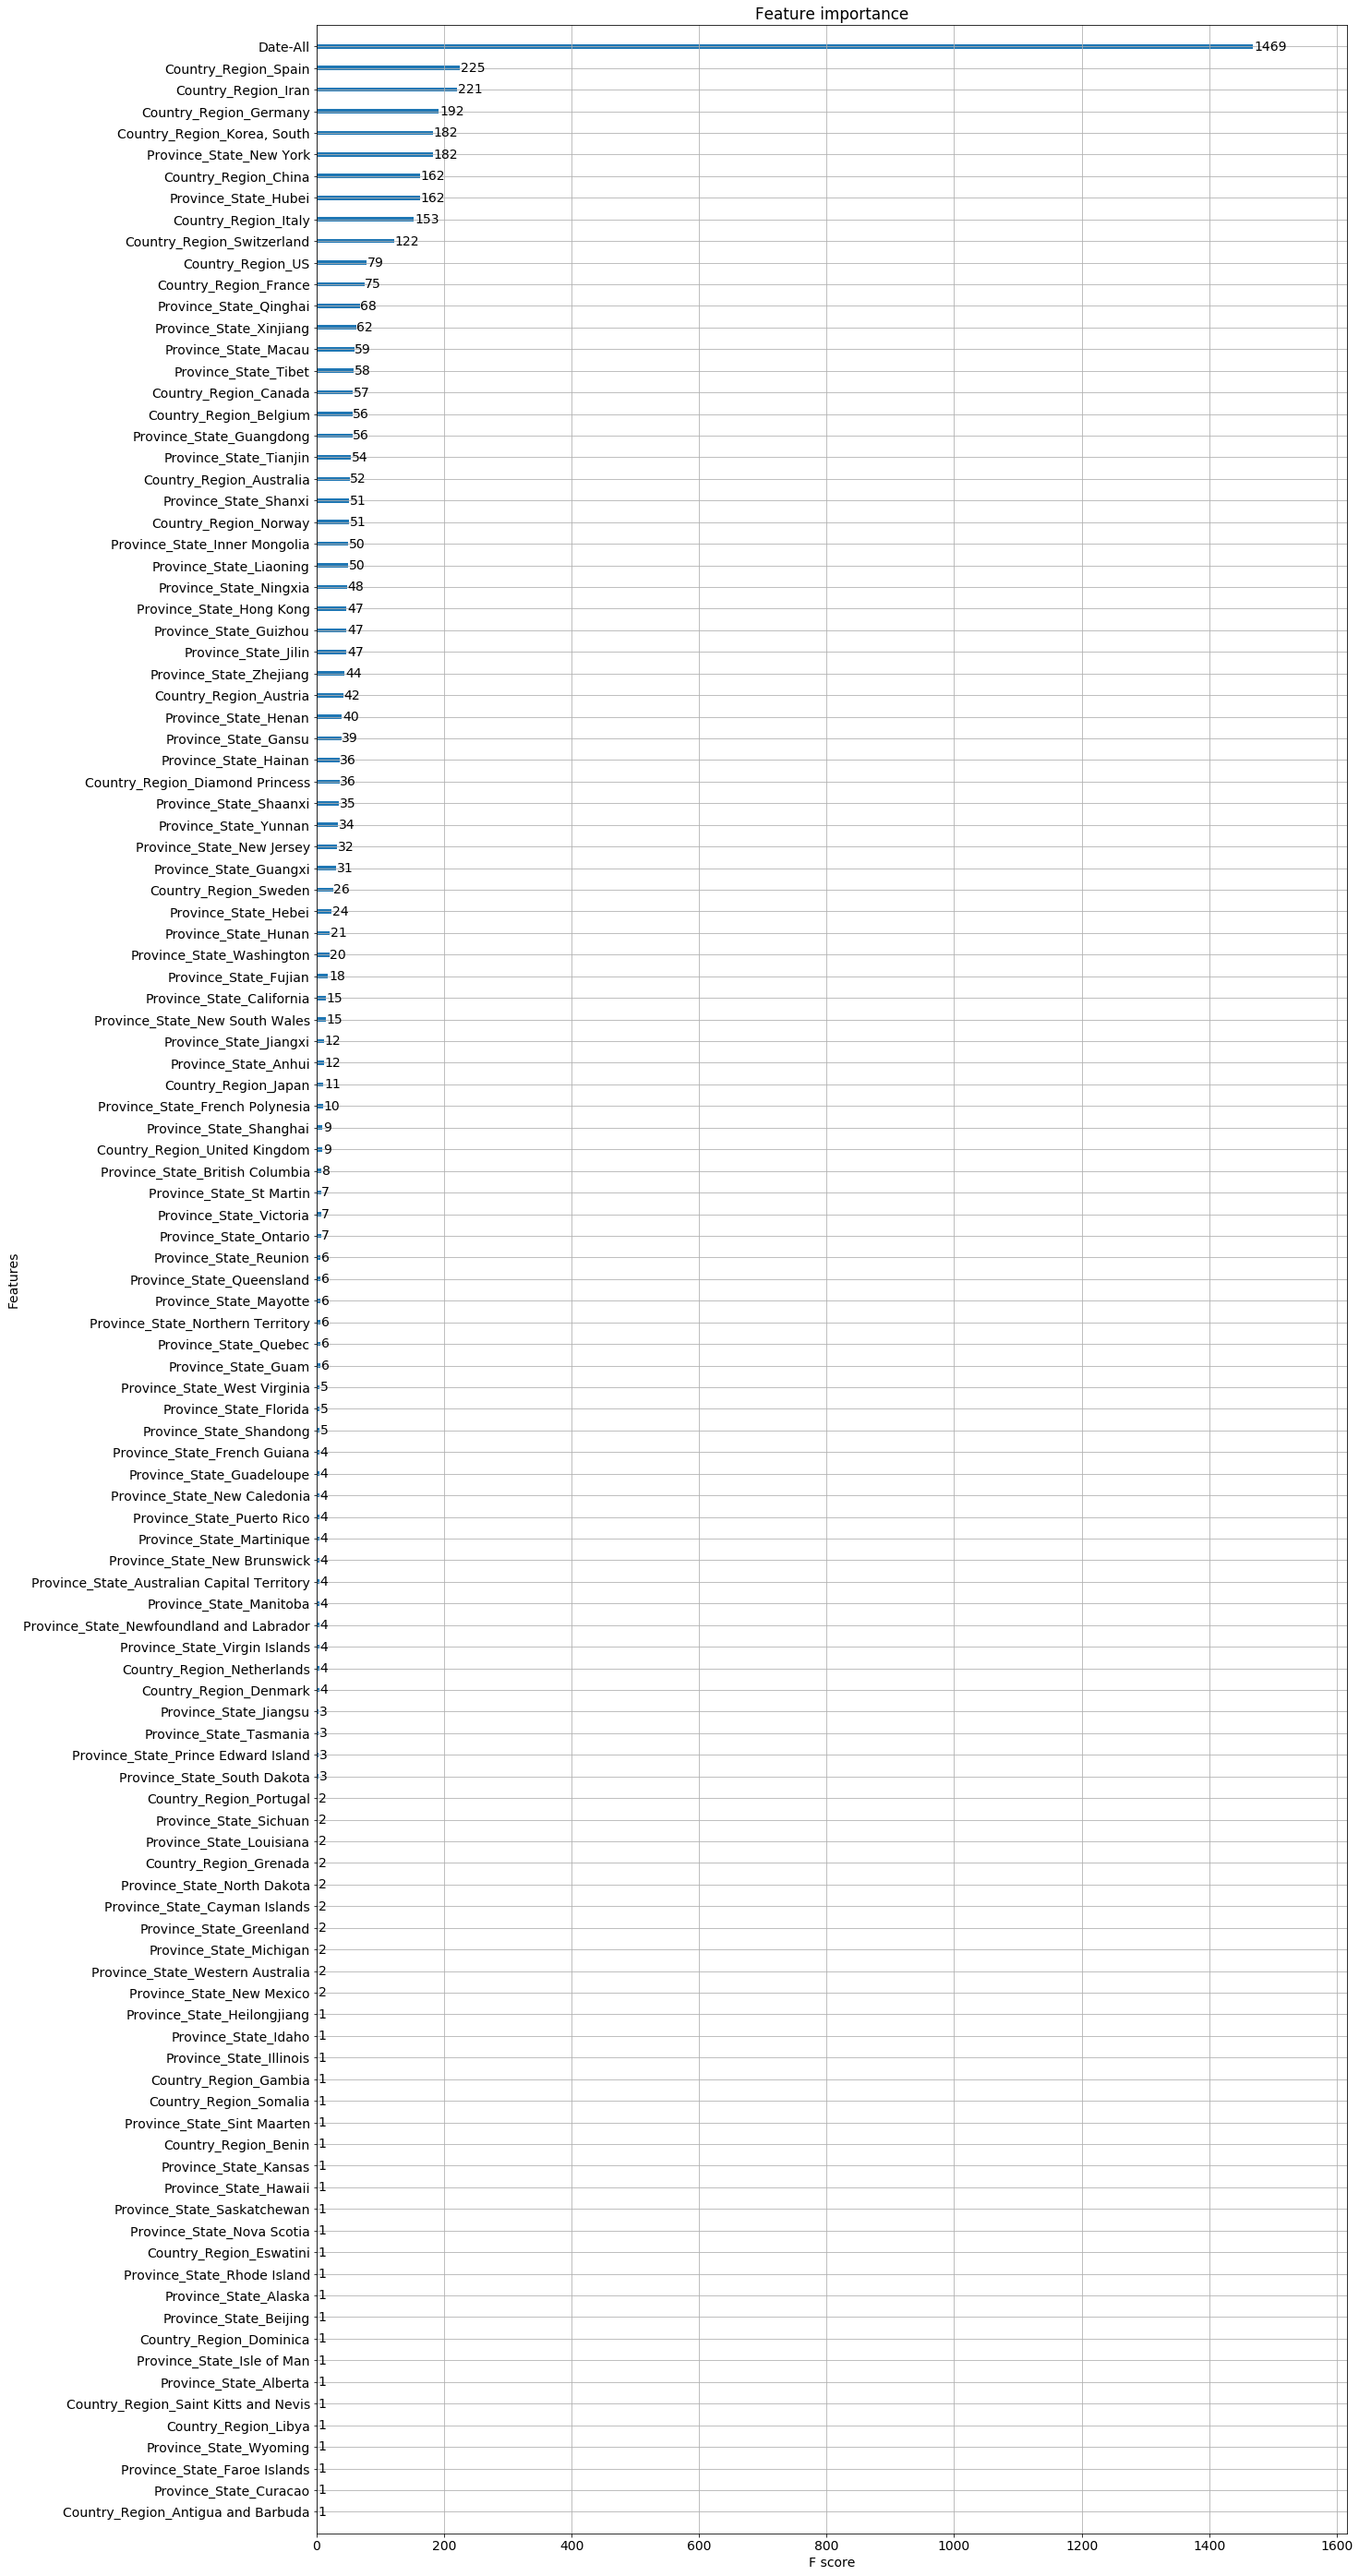

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,50))
_ = plot_importance(reg,ax=ax)
plt.show()

In [50]:
X['yPred'] = reg.predict(X.drop(['Date'],1))
X['yPred'] = X['yPred'].apply(round)
X.loc[X['yPred'] < 0, 'yPred'] = 0
X.loc[:covid19_train.ForecastId.max(),'ConfirmedCases'] = y_train_CC

In [51]:
np.sqrt(mean_squared_error(y_true=X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                   y_pred=X.loc[~X['ConfirmedCases'].isna()]['yPred']))

1673.8882972355186

In [52]:
r2_score(X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                               X.loc[~X['ConfirmedCases'].isna()]['yPred'])

0.781384662825823

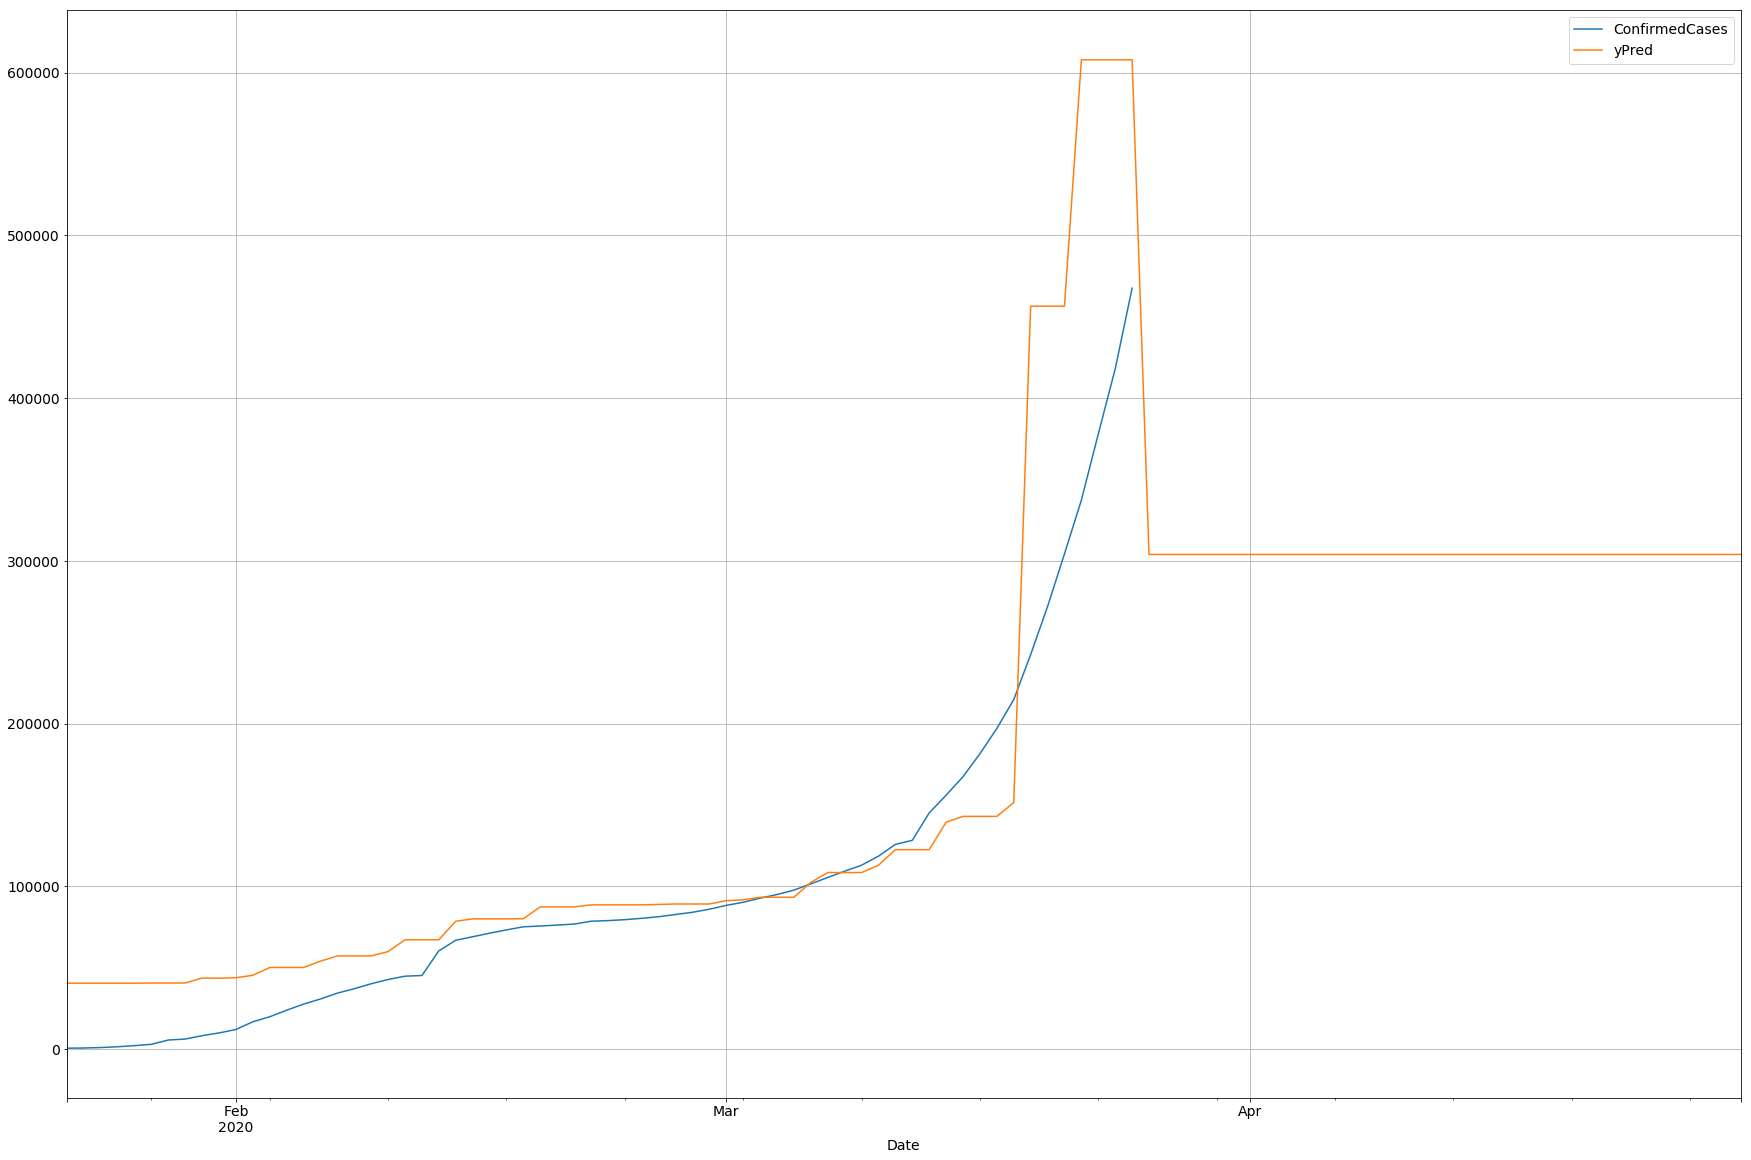

In [53]:
X.set_index('Date').resample('D')[['ConfirmedCases']].sum().replace(0,np.nan).join(X.set_index('Date').resample('D')[['yPred']].sum()).plot(grid=True)